Airline AI Assistant - this is an extension of a previous project "Airline AI Assistant". In this notebook I will be creating an Agent to handle various tasks for Airline passengers using DALL-E-3
- Note: Image generation is about $0.04 for each image.

In [1]:
import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

Load in the API keys

In [2]:
load_dotenv()

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-4o-mini"
openai = OpenAI()

OpenAI API Key exists and begins sk-proj-


System Prompts

In [3]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

# This last system message is a good way to ensure the agent does not hallucinate

Forcing dark mode in Gradio

In [4]:
force_dark_mode = """
function refresh() {
    const url = new URL(window.location);
    if (url.searchParams.get('__theme') !== 'dark') {
        url.searchParams.set('__theme', 'dark');
        window.location.href = url.href;
    }
}
"""

Chat Function

In [5]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages", js=force_dark_mode).launch()

* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


#### Tools
- Tools are an incredibly powerful feature provided by the frontier LLMs.
- With tools, you can write a function, and have the LLM call that function as part of its response.
- Sounds almost spooky.. we're giving it the power to run code on our machine? Well, kinda.

In [6]:
ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [7]:
ticket_availability = {"london": "11th,12th", "paris": "13th,14th", "tokyo": "15th,16th", "berlin": "13th,14th"}

def get_ticket_availability(destination_city):
    print(f"Tool get_ticket_dates called for {destination_city}")
    city = destination_city.lower()
    return ticket_availability.get(city, "Unknown")

In [8]:
get_ticket_price("Berlin")

Tool get_ticket_price called for Berlin


'$499'

In [9]:
get_ticket_availability("Berlin")

Tool get_ticket_dates called for Berlin


'13th,14th'

In [10]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [11]:
# There's a particular dictionary structure that's required to describe our function:

availability_function = {
    "name": "get_ticket_availability",
    "description": "Call this whenever you need to know the date of a flight to a particular city, for example when a customer asks 'Are there any available flights to this city?'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [12]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function},
         {"type": "function", "function": availability_function}]

#### Getting OpenAI to use our Tool
- There's some fiddly stuff to allow OpenAI "to call our tool"
- What we actually do is give the LLM the opportunity to inform us that it wants us to run the tool.
- Here's how the new chat function looks:

In [13]:
def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    if tool_call.function.name == "get_ticket_price":
        arguments = json.loads(tool_call.function.arguments)
        city = arguments.get('destination_city')
        price = get_ticket_price(city)
        response = {
            "role": "tool",
            "content": json.dumps({"destination_city": city,"price": price}),
            "tool_call_id": message.tool_calls[0].id
        }
        return response, city
    
    elif tool_call.function.name == "get_ticket_availability":
        arguments = json.loads(tool_call.function.arguments)
        city = arguments.get('destination_city')
        availability = get_ticket_availability(city)  
        response = {
            "role": "tool",
            "content": json.dumps({"destination_city": city, "availability": availability}),
            "tool_call_id": message.tool_calls[0].id
        }
        return response, city


This function unpacks the message from the tool call

In [14]:
# # We have to write that function handle_tool_call:

# def handle_tool_call(message):
#     tool_call = message.tool_calls[0]
#     arguments = json.loads(tool_call.function.arguments)
#     city = arguments.get('destination_city')
#     price = get_ticket_price(city)
#     response = {
#         "role": "tool",
#         "content": json.dumps({"destination_city": city,"price": price}),
#         "tool_call_id": tool_call.id
#     }
#     return response, city

#### Chat Function
- we have added in two new message lines to allow our agent to use this tool
    - adding in print statments could make this more clear

- messages = response.choices[0].message 
    - This is nothing more than what we get back from our Assistant asking to run a tool
- response, city = handle_tool_call(message)
    - This is the result of calling the tool function

In [15]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message 
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [16]:
gr.ChatInterface(fn=chat, type="messages", js=force_dark_mode).launch()

* Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.


Using DALL-E-3 for image generation

In [17]:
import base64
from io import BytesIO
from PIL import Image

Function to generate images from OpenAI

In [18]:
def artist(city):
    image_response = openai.images.generate( 
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

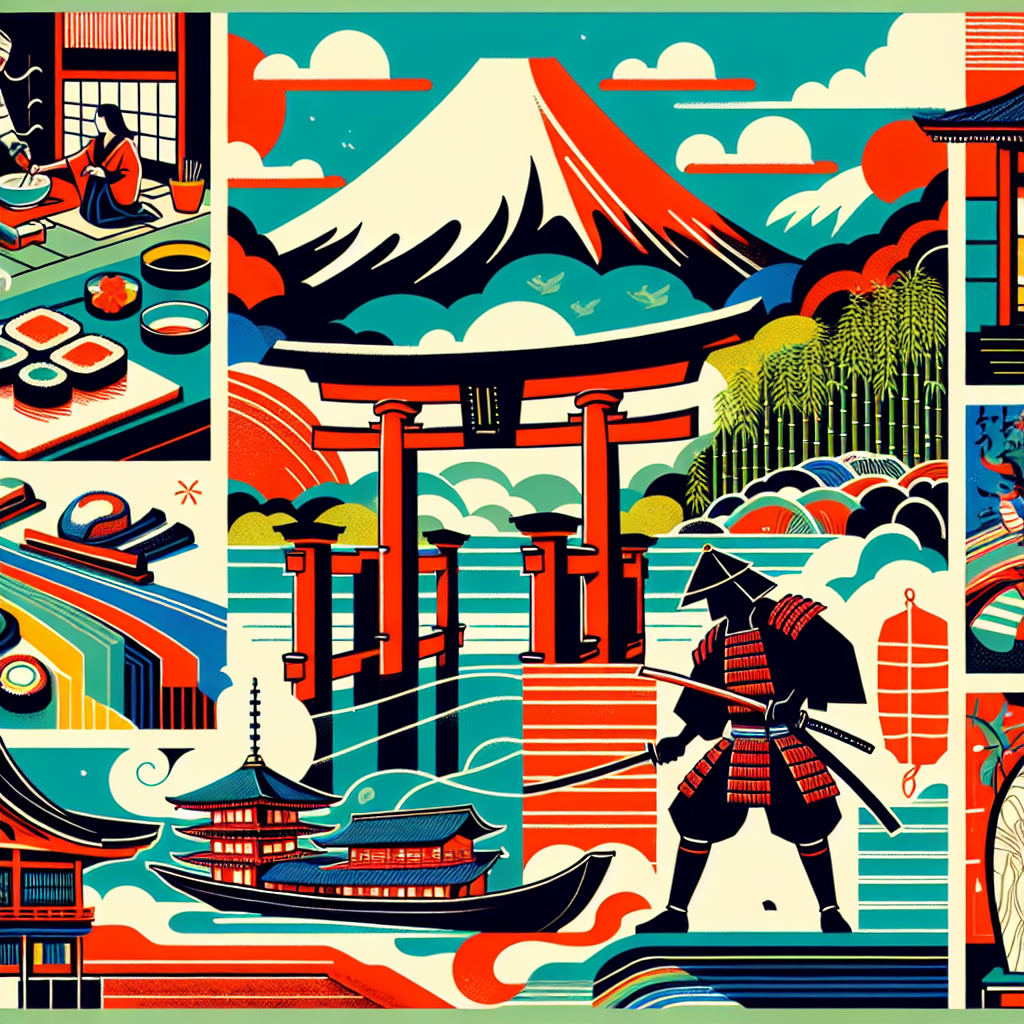

In [19]:
image = artist("Japan")
display(image)

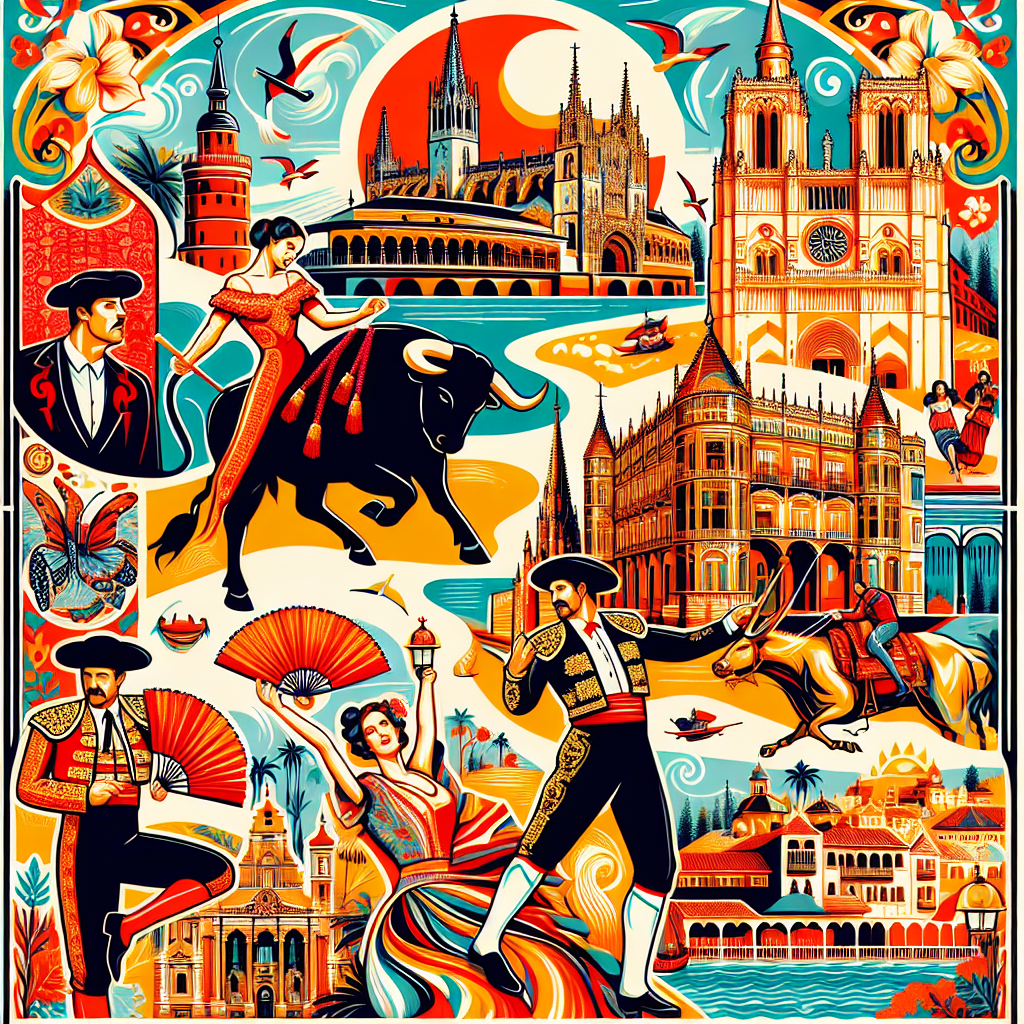

In [20]:
image = artist("Spain")
display(image)